In [1]:
import numpy as np
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

from plotting_utils import plot_traj2, plot_traj3

In [2]:
import matplotlib as mpl

mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['xtick.labelsize'] = 20
mpl.rcParams['ytick.labelsize'] = 20
mpl.rcParams["axes.labelsize"] = 20
mpl.rcParams['legend.fontsize'] = 33
mpl.rcParams['axes.titlesize'] = 26
mpl.rcParams['text.usetex'] = True
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

In [3]:
SEEDS5 = [1, 2, 3, 4, 5]
SEEDS2 = [1, 2]
N_EPOCHS = 64
L2_REG = 1.0
LRS = [3e-5, 1e-4, 3e-4, 1e-3, 3e-3, 0.01, 0.03, 0.1, 0.3]
SM_MEDIUM = 1.0

In [4]:
l2_reg = L2_REG
sm_coef = SM_MEDIUM
result_dir = "../results"

In [5]:
seeds = [1, 2]

datasets = [
    "yacht", 
    "energy",
    "concrete",
    "acsincome",
    "kin8nm",
    "power",
    # "emotion",
]
# objective = "chi2"
objective = "superquantile_lite"

obj_names = {
    "superquantile_lite": "CVaR", 
    "superquantile": "CVaR", 
    "superquantile_hard": "0.75-Superquantile", 
    "extremile": "Extremile", 
    "extremile_hard": "2.5-Extremile", 
    "esrm": "ESRM",
    "esrm_hard": "2-ESRM",
    "chi2": r"$\chi^2$-Divergence Ball",
}

n_class_dict = {
    "yacht": None, 
    "energy": None,
    "concrete": None,
    "kin8nm": None,
    "power": None,
    "acsincome": None,
    "iwildcam_std": 60, 
    "emotion": 6,
}

eval_limits = {
    "yacht": 100000, 
    "energy": 100000,
    "concrete": 100000,
    "kin8nm": 100000,
    "power": 100000,
    "acsincome": 100000,
    "emotion": 400000,
}

time_limits = {
    "yacht": 2, 
    "energy": 2,
    "concrete": 2,
    "kin8nm": 8,
    "power": 8,
    "acsincome": 8,
    "emotion": 30,     
}

loss_dict = {
    "yacht": "squared_error", 
    "energy": "squared_error",
    "concrete": "squared_error", 
    "acsincome": "squared_error",
    "kin8nm": "squared_error", 
    "power": "squared_error", 
    "iwildcam_std": "multinomial_cross_entropy", 
    "emotion": "multinomial_cross_entropy", 
}

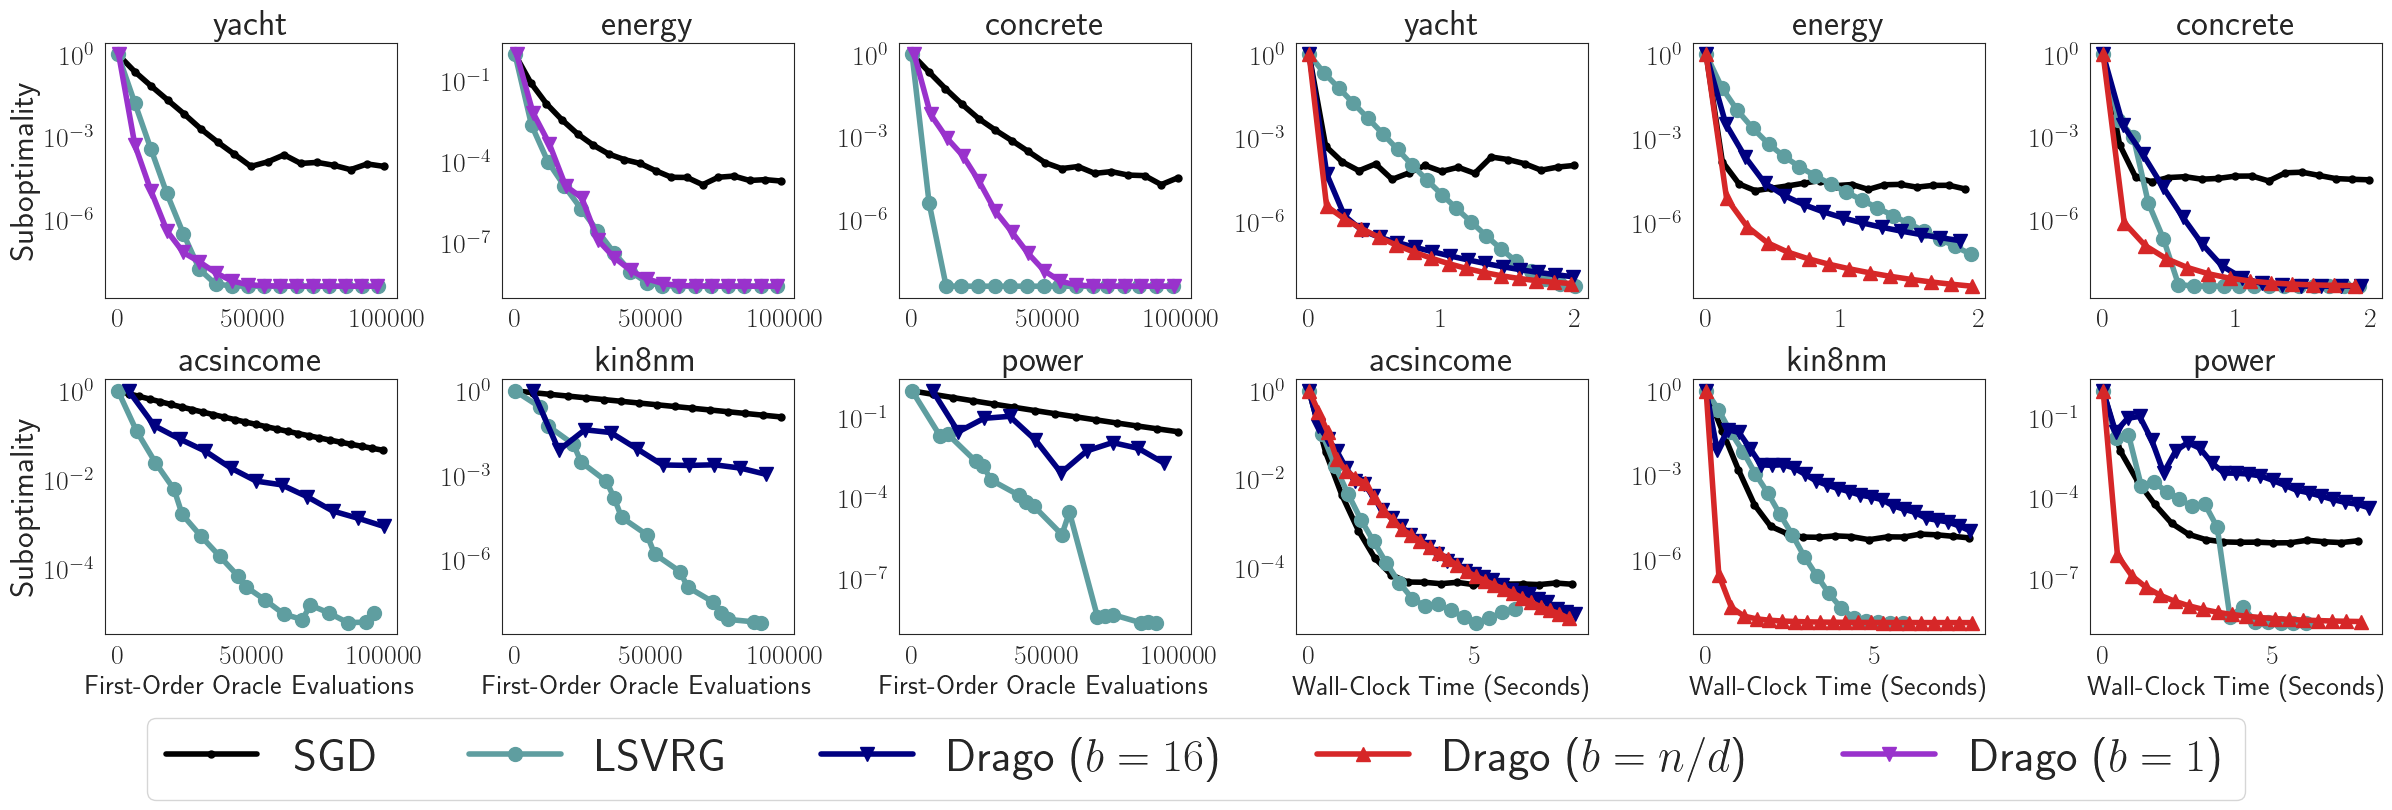

In [6]:
sns.set_style("white")

verbose = False

n_row = 2
n_col = 6
fig, axes = plt.subplots(n_row, n_col, figsize=(4 * n_col, 3.6 * n_row))

plots = [(0, 0), (0, 1), (0, 2), (1, 0), (1, 1), (1, 2)]

plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },
    {
        "optimizer": "slsvrg",
        "label": "LSVRG",
        # "color": "tab:red",
        "color": "cadetblue",
        "linestyle": "solid",
        "marker": "o",
    },
    {
        "optimizer": "drago",
        "label": r"Drago ($b=1$)",
        "color": "darkorchid",
        "linestyle": "solid",
        "marker": "v",
    },
    {
        "optimizer": "drago_auto",
        "label": r"Drago ($b=16$)",
        "color": "navy",
        "linestyle": "solid",
        "marker": "v",
    },
    # {
    #     "optimizer": "drago_batch",
    #     "label": r"Drago ($b=n/d$)",
    #     "color": "tab:red",
    #     "linestyle": "solid",
    #     "marker": "o",
    # },
]

for i, dataset in enumerate(datasets):
    r = plots[i][0]
    c = plots[i][1]

    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": loss_dict[dataset], 
        "n_class": n_class_dict[dataset],
        "sm_coef": sm_coef,
        "smoothing": "l2"
    }
    if dataset in ["yacht", "energy", "concrete"]:
        for plot_cfg in plot_cfgs:
            if not (plot_cfg["optimizer"] == "drago_auto"):
                plot_traj2(
                    axes[r, c], 
                    dataset, 
                    model_cfg, 
                    plot_cfg, 
                    seeds, 
                    # plot_all=False, 
                    verbose=verbose,
                    n_points=16,
                    markersize=10,
                    out_path=result_dir,
                    # n_epochs=64,
                    limit=eval_limits[dataset]
                )
    else:
        for plot_cfg in plot_cfgs:
            if not (plot_cfg["optimizer"] == "drago"):
                plot_traj2(
                    axes[r, c], 
                    dataset, 
                    model_cfg, 
                    plot_cfg, 
                    seeds, 
                    # plot_all=False, 
                    verbose=verbose,
                    n_points=16,
                    markersize=10,
                    out_path=result_dir,
                    # n_epochs=64,
                    limit=eval_limits[dataset]
                )
    # axes[r, c].set_xticks([])
    axes[r, c].set_yscale("log")
    # axes[r, c].set_title(titles[dataset])
    axes[r, c].set_title(dataset)
    if r == n_row - 1:
        axes[r, c].set_xlabel("First-Order Oracle Evaluations")
        # axes[r, c].set_xticks([0, 16, 32, 48, 64])


plot_cfgs = [
    {
        "optimizer": "sgd",
        "label": "SGD",
        "color": "black",
        "linestyle": "solid",
        "marker": ".",
    },
    {
        "optimizer": "slsvrg",
        "label": "LSVRG",
        # "color": "tab:red",
        "color": "cadetblue",
        "linestyle": "solid",
        "marker": "o",
    },
    {
        "optimizer": "drago_auto",
        "label": r"Drago ($b=16$)",
        "color": "navy",
        "linestyle": "solid",
        "marker": "v",
    },
    {
        "optimizer": "drago_batch",
        "label": r"Drago ($b=n/d$)",
        "color": "tab:red",
        "linestyle": "solid",
        "marker": "^",
    },
]

plots = [(0, 3), (0, 4), (0, 5), (1, 3), (1, 4), (1, 5)]

for i, dataset in enumerate(datasets):
    r = plots[i][0]
    c = plots[i][1]

    model_cfg = {
        "objective": objective, 
        "l2_reg": l2_reg, 
        "loss": loss_dict[dataset], 
        "n_class": n_class_dict[dataset],
        "sm_coef": sm_coef,
        "smoothing": "l2"
    }
    if dataset in ["yacht", "energy", "concrete"]:
        for plot_cfg in plot_cfgs:
            # if not (plot_cfg["optimizer"] == "drago_auto"):
            plot_traj3(
                axes[r, c], 
                dataset, 
                model_cfg, 
                plot_cfg, 
                seeds, 
                # plot_all=False, 
                verbose=verbose,
                n_points=16,
                markersize=10,
                out_path=result_dir,
                # n_epochs=64,
                limit=time_limits[dataset]
            )
    else:
        for plot_cfg in plot_cfgs:
            # if not (plot_cfg["optimizer"] == "drago_auto" and dataset == "emotion"):
            plot_traj3(
                axes[r, c], 
                dataset, 
                model_cfg, 
                plot_cfg, 
                seeds, 
                # plot_all=False, 
                verbose=verbose,
                n_points=16,
                markersize=10,
                out_path=result_dir,
                # n_epochs=64,
                limit=time_limits[dataset]
            )
    # axes[r, c].set_xticks([])
    axes[r, c].set_yscale("log")
    # axes[r, c].set_title(titles[dataset])
    axes[r, c].set_title(dataset)
    if r == n_row - 1:
        axes[r, c].set_xlabel("Wall-Clock Time (Seconds)")
        # axes[r, c].set_xticks([0, 16, 32, 48, 64])

axes[0, 0].set_ylabel("Suboptimality", fontsize=24)
axes[1, 0].set_ylabel("Suboptimality", fontsize=24)

h1, l1 = axes[0, 0].get_legend_handles_labels()
h2, l2 = axes[0, 3].get_legend_handles_labels()

handles = h2 + [h1[-1]]
labels = l2 + [l1[-1]]

fig.legend(handles=handles, labels=labels, loc='center',
        bbox_to_anchor=(0.5, -0.06), ncol=5)
fig.tight_layout(pad=1.0)
plt.show()